# Introduction to Data Science
## Data Prep, Modeling and Evaluation

Sophia Maria Tsilerides

***

We will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. Full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal is to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. 


### Data preparation 
Below we define a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import statistics
import math
import os
import warnings
warnings.filterwarnings('ignore')

In [11]:
def cleanBosonData(infile_name):
    #read and load data in DataFrame (line 1)
    data = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + infile_name, sep=','))
    
    #converting Label column (lines 2 - 4)
    data['Y'] = 0
    data.Y[data.Label == data['Label'].value_counts().idxmin()] = 1
    del data['Label']
    
    #Dealing with missing values (lines 5 - 16)
    mean_dict = {}
    
    mv_df = data.describe()
    s = mv_df.iloc[3] == -999
    s = s.to_dict()
    for k,v in s.items():
        if v == True:
            data[k+'_mv'] = 0
            data[k+'_mv'][data[k] == -999] = 1 
            x = statistics.mean(list(filter(lambda a: a != -999, data[k].tolist())))
            mean_dict[k] = x
            
    for k,v in mean_dict.items():
        data[k][data[k+'_mv'] == 1] = v
    
    #Rescaling (line 17 - 18)
    for i in range(1,len(data.columns)-(1 + len(mean_dict))):
        data[data.columns[i]] = pd.DataFrame(preprocessing.scale(data[data.columns[i]]))
        
    return data

### Basic evaluations
We do some basic evaluations using the out-of-the box logistic regression (LR) model and support vector machine (SVM) and plot ROC for the LR and SVM model.

We can use the `cleanBosonData` function created to clean our training and testing data files.

In [12]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model

from sklearn import svm

from sklearn.metrics import roc_curve, auc

In [15]:
x_train = data_train.drop(["Y","EventId"], 1)

y_train = data_train["Y"]

x_test = data_test.drop(["Y","EventId"], 1)

y_test = data_test["Y"]

In [16]:
logreg = linear_model.LogisticRegression(C = 1e30)
logreg = logreg.fit(x_train, y_train)

In [17]:
my_svm = svm.SVC(kernel='linear', probability=True)
my_svm = my_svm.fit(x_train, y_train)

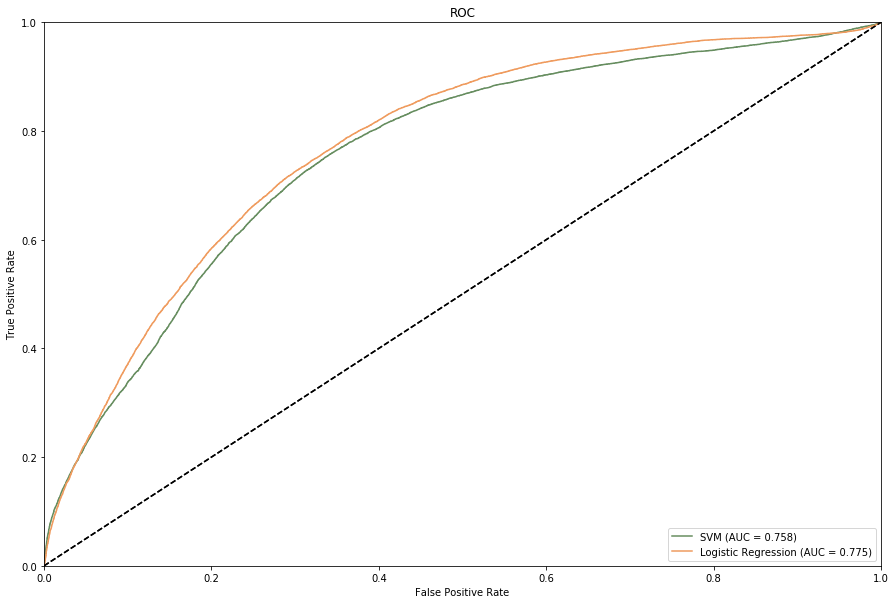

In [18]:
def plotUnivariateROC(preds, truth, label_string):

    fpr, tpr, thresholds = roc_curve(truth, preds)

    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

fig = plt.figure(figsize = (15, 10));

plotUnivariateROC(my_svm.predict_proba(x_test)[:,1], y_test, "SVM");
plotUnivariateROC(logreg.predict_proba(x_test)[:,1], y_test, "Logistic Regression");


We want our AUC close to 1, so according to the above, the logistic regression model is better at ranking the test set. There are times when the lines overlap, for example where true positive rate is less than about .3 and false positive rate is less than .1, and again when they are both near 1. That means that for every false positive rate, there's a better true positive rate for SVM. 

A closer look at performance against classification thresholds also shows SVM outperforms Logistic Regression at certain thresholds. Specifically, when the threshold is less than .3, SVM has a higher false positive rate and when the threshold is less than .2 and greater than .7 SVM has a higher true positive rate. 

Whether to select a logistic regression model or an SVM model depends on the business problem: whether we need high recall or high precision at those thresholds. We can use charts to see which model is better.


In [35]:
s_fpr, s_tpr, s_thresholds = roc_curve(y_test, my_svm.predict_proba(x_test)[:,1])
l_fpr, l_tpr, l_thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

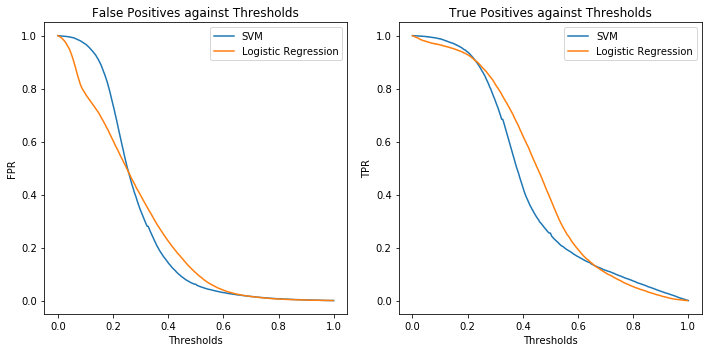

In [44]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(s_thresholds, s_fpr, label = "SVM")
plt.plot(l_thresholds,l_fpr, label = 'Logistic Regression')
plt.title('False Positives against Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('FPR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(s_thresholds, s_tpr, label = "SVM")
plt.plot(l_thresholds,l_tpr, label = 'Logistic Regression')
plt.title('True Positives against Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('TPR')
plt.legend()

plt.tight_layout();

### Model selection with cross-validation 
We might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def xValSVM(dataset, label_name, k, cs):
    
    #Map each instance to a fold (line 1)
    kf = KFold(n_splits = k)
    
    #initalize empty dictionary (line 2)
    aucs = {}
    
    #split the data for each fold, train SVM, compute AUC, store AUC (lines 3 - 13)
    for train_index, test_index in kf.split(dataset):
        train = dataset.iloc[train_index]
        test =  dataset.iloc[test_index]

        for i in cs:
            my_svm = svm.SVC(kernel='linear', probability=True, C=i)
            my_svm.fit(train.drop([label_name,"EventId"], 1), train[label_name])
            auc = roc_auc_score(test[label_name], my_svm.predict_proba(test.drop([label_name,"EventId"], 1))[:,1])        
                
            if i in aucs:
                aucs[i].append(auc)
            else:
                aucs[i] = [auc]

    return aucs

In [20]:
#generating cs
cs = []
for i in range(-8, 2):
    cs.append(10 ** i)

In [21]:
#calling function
aucs = xValSVM(data_train, 'Y', 10, cs)

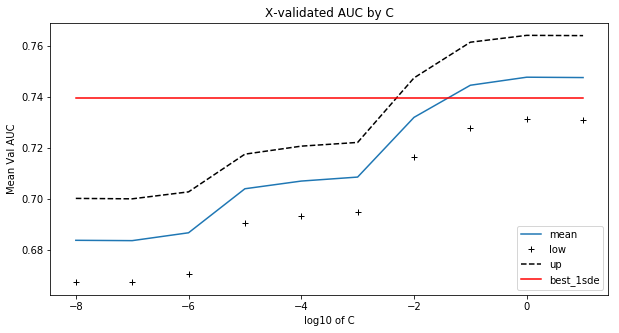

In [22]:
#creating a dictionary of means and StdErr for AUCs
xval_dict = {'c':[], 'mean':[], 'StdErr':[]}
for i in range(-8, 2):
    xval_dict['c'].append(i)
    xval_dict['mean'].append(np.array(aucs[10**i]).mean())
    xval_dict['StdErr'].append(np.sqrt(np.array(aucs[10**i]).var()/10))

#finding the 1 standard error rule
index = xval_dict['mean'].index(max(xval_dict['mean']))
max_1std = xval_dict['mean'][index]-xval_dict['StdErr'][index]

#storing series in a DataFrame for plotting
res = pd.DataFrame(xval_dict)
res['low'] = res['mean'] - 2*res['StdErr']
res['up'] = res['mean'] + 2*res['StdErr']
res['best_1sde'] = max_1std 

#plotting
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)

plt.plot(res['c'], res['mean'])
plt.plot(res['c'], res['low'], 'k+')
plt.plot(res['c'], res['up'], 'k--')
plt.plot(res['c'], res['best_1sde'], 'r')

plt.legend(loc = 4)
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')
plt.title('X-validated AUC by C');

Overall the model parameter selection performed with cross validation had a maximum 1 standard error of about .74 while the AUC for out-of-the-box was .756. So no, it did not beat the out-of-the-box AUC.

Some cross validation parameters returned higher AUCs at certain folds of around .78/.79. It may be that reserving part of the original dataset for testing induces some amount of bias, causing the certain folds to perform better than the others.


### Learning Curve with Bootstrapping

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.


In [24]:
def modBootstrapper(train, test, nruns, sampsize, lr, c = None):
    
    auc_res = []
    
    for i in range(nruns):
        train_samp = train.loc[np.random.choice(len(train), sampsize, replace = True)]
        
        if lr ==1:
            logreg = linear_model.LogisticRegression()
            logreg.fit(train_samp.drop(['EventId', 'Y'],1), train_samp['Y'])
            try:
                auc_res.append(roc_auc_score(test['Y'], logreg.predict_proba(test.drop(['EventId', 'Y'],1))[:,1]))
            except:
                oops = 1
        else:
            my_svm = svm.SVC(C=c, kernel = 'linear', probability=True)
            my_svm = my_svm.fit(train_samp.drop(['EventId', 'Y'],1), train_samp['Y'])
            try:
                auc_res.append(roc_auc_score(test['Y'], my_svm.predict_proba(test.drop(['EventId', 'Y'],1))[:,1]))
            except:
                oops = 1
    return (np.mean(auc_res), np.sqrt(np.var(auc_res)))

In [25]:
lr_means = []; lr_sigs = []; samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

for n in samplesizes:
    mean, sig = modBootstrapper(data_train, data_test, nruns = 20 , sampsize= int(n), lr = 1)
    lr_means.append(mean)
    lr_sigs.append(sig)   

In [26]:
s_means = []; s_sigs = []; samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

for n in samplesizes:
    mean, sig = modBootstrapper(data_train, data_test, nruns = 20 , sampsize= int(n), lr = 0, c = 10)
    s_means.append(mean)
    s_sigs.append(sig)   

In [27]:
res4 = pd.DataFrame({'SampleSizes': samplesizes, 
                     'LRMeans':lr_means, 
                     'LRSig': lr_sigs, 
                     "SVMMeans": s_means, 
                     "SVMSig":s_sigs})

res4['LRLow'] = res4['LRMeans'] - 2*res4['LRSig']
res4['LRHigh'] = res4['LRMeans'] + 2*res4['LRSig']
res4['SVMLow'] = res4['SVMMeans'] - 2*res4['SVMSig']
res4['SVMHigh'] = res4['SVMMeans'] + 2*res4['SVMSig']
res4['log2s'] = np.log2(res4['SampleSizes'])

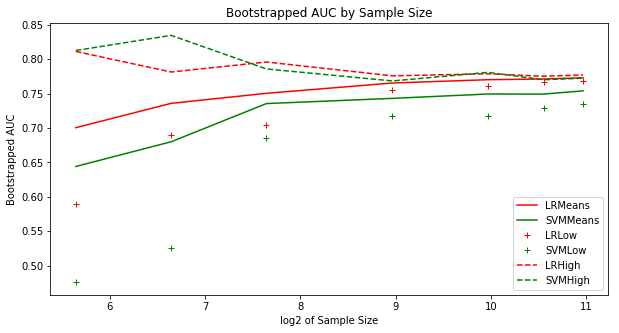

In [29]:
#plotting
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)

plt.plot(res4['log2s'], res4['LRMeans'], 'r')
plt.plot(res4['log2s'], res4['SVMMeans'], 'g')
plt.plot(res4['log2s'], res4['LRLow'], 'r+')
plt.plot(res4['log2s'], res4['SVMLow'], 'g+')
plt.plot(res4['log2s'], res4['LRHigh'], 'r--')
plt.plot(res4['log2s'], res4['SVMHigh'], 'g--')

plt.legend(loc = 4)
ax.set_xlabel('log2 of Sample Size')
ax.set_ylabel('Bootstrapped AUC')
plt.title('Bootstrapped AUC by Sample Size');

Of the two algorithms, logistic regression is better suited to fit smaller sample sizes. This can be inferred from the higher bootstrapped AUC and the tighter standard deviation around the means for the logistic regression versus the SVM model. 

The investment in more data would not be worth it because as sample size increases past 200, AUC levels off and there is no significant improvement in either model.


**Something to note:**
Cross validation error could underestimate or overestimate the true test error depending on the size of training data sets. Variance is caused by big training datasets. However, for bias, mean cross validation error could range depending on the modeling methods because the search for the best model is strongly affected by validation where the selection of parameters (like C in SVM) depend on the particular training set we get. Bias can also be introduced depending on how performance of the model varies with the size of a training set. The larger the training set, the better the performance of the classifier until a certain point where more data would not significantly improve the model. With smaller training sets, cross validation results in an overestimate of prediction error causing cross validation to be bias upward against true error.   